<a href="https://colab.research.google.com/github/olliemamuda/Individual_Short_Project/blob/main/ISP_code_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GA applied to Simple Neural Network

## Data Pre-processing

First we set a random seed for repeatability

In [ ]:
import numpy as np
import random

randomSeed = 0
np.random.seed(randomSeed)
random.seed(randomSeed)

### Processing the Iris dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# open the dataset
dataset = "iris"
df = pd.read_csv("iris/iris.data", names=["sepal_length",
                                             "sepal_width",
                                             "petal_length",
                                             "petal_width",
                                             "class"])

# map classes to 1 for Iris Setosa, 0 otherwise
oneHotEncode = False
df["class"] = list(map(lambda x: 1 if(x == "Iris-versicolor") else 0, df["class"]))

# get X and y from df
y = df.pop("class").to_numpy()
X = df.to_numpy()
numClasses = len(np.unique(y))

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=randomSeed)

### Processing the MNIST Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

oneHotEncode = True
sideLength = 8

# load the dataset and split
dataset = "mnist"
X, y = load_digits(return_X_y=True)
X = np.array(X)
y = np.array(y)
numClasses = len(np.unique(y))

# One Hot Encode y
if(oneHotEncode):
    y = y.reshape(-1, 1)
    y = OneHotEncoder().fit_transform(y).toarray()
else:
    y = np.array(list(map(lambda el: 1 if(el == 0) else 0, y)))

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, random_state=randomSeed)

### Processing the Fashion MNIST Dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

oneHotEncode = True
sideLength = 28

# open the datasets
dataset = "fashionMnist"
df_test = pd.read_csv("fashionMNIST/fashion-mnist_test.csv")
df_tr = pd.read_csv("fashionMNIST/fashion-mnist_train.csv")

# Make X_tr, ..., y_test
y_tr = df_tr.pop("label").to_numpy()
X_tr = df_tr.to_numpy()
y_test = df_test.pop("label").to_numpy()
X_test = df_test.to_numpy()
numClasses = len(np.unique(y_tr, axis=0))

# One-Hot-Encode
if(oneHotEncode):
    y_tr = y_tr.reshape(-1, 1)
    y_tr = OneHotEncoder().fit_transform(y_tr).toarray()

    y_test = y_test.reshape(-1, 1)
    y_test = OneHotEncoder().fit_transform(y_test).toarray()
else:
    y_tr = np.array(list(map(lambda el: 1 if(el == 0) else 0, y_tr)))
    y_test = np.array(list(map(lambda el: 1 if(el == 0) else 0, y_test)))

## Model Training

### Train logistic regression model

Only use for Iris, or MNIST with 1d labels (no one hot encoding)

In [ ]:
from sklearn.linear_model import LogisticRegression

if(oneHotEncode):
    print("error, one hot encoding.")

# liblinear recommended from sklearn documentation
lrModel = LogisticRegression(solver="lbfgs", random_state=randomSeed) # penaulty = None
lrModel.fit(X_tr, y_tr)

#evaluation
print("Logistic Regression Score on training data: "+str(lrModel.score(X_tr, y_tr)))
print("Logistic Regression Score on test data: "+str(lrModel.score(X_test, y_test)))

Logistic Regression Score on training data: 0.7523809523809524
Logistic Regression Score on test data: 0.6444444444444445


### Simple MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

if(dataset == "fashionMnist"):
    hidden_layer_sizes = (50,)# (128,)
    batch_size = "auto" #1000
else:
    hidden_layer_sizes = (50,)
    batch_size = "auto"

nnModel = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                        batch_size=batch_size,
                        random_state=randomSeed)
nnModel.fit(X_tr, y_tr)

print("NN accuracy on training set: "+str(nnModel.score(X_tr, y_tr)))
print("NN accuracy on test set: "+str(nnModel.score(X_test, y_test)))

NN accuracy on training set: 0.8522666666666666
NN accuracy on test set: 0.8147


### Noise vs Data Processing

In [ ]:
if(dataset == "fashionMnist"):
    maxPixel = 255 # 17
else:
    maxPixel = 17

# Create dataset from noise and data
noise_tr = np.random.randint(0, maxPixel, (X_tr.shape[0], X_tr.shape[1]))
X_noisy_tr = np.concatenate((noise_tr, X_tr))
y_noisy_tr = np.concatenate(([0 for _ in range(0, X_tr.shape[0])], [1 for _ in range(0, X_tr.shape[0])]), axis=0)

noise_test = np.random.randint(0, maxPixel, (X_test.shape[0], X_tr.shape[1]))
X_noisy_test = np.concatenate((noise_test, X_test))
y_noisy_test = np.concatenate(([0 for _ in range(0, X_test.shape[0])], [1 for _ in range(0, X_test.shape[0])]), axis=0)

# Shuffle
shuffleIndices_tr = np.arange(X_noisy_tr.shape[0])
np.random.shuffle(shuffleIndices_tr)
X_noisy_tr = X_noisy_tr[shuffleIndices_tr]
y_noisy_tr = y_noisy_tr[shuffleIndices_tr]

shuffleIndices_test = np.arange(X_noisy_test.shape[0])
np.random.shuffle(shuffleIndices_test)
X_noisy_test = X_noisy_test[shuffleIndices_test]
y_noisy_test = y_noisy_test[shuffleIndices_test]

### Noise to Data Preprocessing

In [ ]:
X_noisy = []
y_noisy = []
for i in range(0, len(X_tr)):
    # get ndr and noise
    noiseToDataRatio = np.random.rand() # 0 = noise, 1 = data
    noise = np.random.randint(0, maxPixel, (X_tr.shape[1]))
    data = X_tr[i]

    # combine and store
    dp = (noise * (1 - noiseToDataRatio)) + (data * noiseToDataRatio)
    X_noisy.append(dp)
    y_noisy.append(noiseToDataRatio)

X_noisy = np.array(X_noisy)
y_noisy = np.array(y_noisy)
X_noisy_tr, X_noisy_test, y_noisy_tr, y_noisy_test = train_test_split(X_noisy, y_noisy, test_size=0.1)

### Noise vs Data NN Model (classification)

In [ ]:
if(dataset == "fashionMnist"):
    batch_size = "auto" # 1000
else:
    batch_size = "auto"

denoisedModel = "nn classification"

# Train
isDigitModelnn = MLPClassifier(hidden_layer_sizes = (50,), random_state=randomSeed, batch_size=batch_size)
isDigitModelnn.fit(X_noisy_tr, y_noisy_tr)

print("NN accuracy on training set: "+str(isDigitModelnn.score(X_noisy_tr[:1000], y_noisy_tr[:1000])))
print("NN accuracy on test set: "+str(isDigitModelnn.score(X_noisy_test[:1000], y_noisy_test[:1000])))

NN accuracy on training set: 1.0
NN accuracy on test set: 1.0


### Noisy to Data NN Model (regression)

In [ ]:
from sklearn.neural_network import MLPRegressor

if(dataset == "fashionMnist"):
    batch_size = "auto" # 1000
else:
    batch_size = "auto"

denoisedModel = "nn regression"

# Train
isDigitModelNNreg = MLPRegressor(hidden_layer_sizes = (300, 100), random_state=randomSeed, batch_size=batch_size)
isDigitModelNNreg.fit(X_noisy_tr, y_noisy_tr)

print("NN accuracy on training set: "+str(isDigitModelNNreg.score(X_noisy_tr[:1000], y_noisy_tr[:1000])))
print("NN accuracy on test set: "+str(isDigitModelNNreg.score(X_noisy_test[:1000], y_noisy_test[:1000])))

NN accuracy on training set: 0.9684778871676885
NN accuracy on test set: -0.021113370860475378


### Noise vs LR Model

In [ ]:
from sklearn.linear_model import LogisticRegression

denoisedModel = "lr"

# Train
isDigitModellr = LogisticRegression(random_state=randomSeed)
isDigitModellr.fit(X_digit_tr, y_digit_tr)

print("NN accuracy on training set: "+str(isDigitModellr.score(X_digit_tr, y_digit_tr)))
print("NN accuracy on test set: "+str(isDigitModellr.score(X_digit_test, y_digit_test)))

C:\Users\ollie\anaconda3\envs\isp\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NN accuracy on training set: 1.0
NN accuracy on test set: 0.9999


## The Genetic Algorithm

### Helper Functions and Hyperparamaters

Defines hyperparamaters, allele boundaries and initalization function for population

In [ ]:
# Hyperparamaters
N = 100
maxGenerations = 500
numParents = 30
tournamentSizes = 3
mutationRate = 0.01
doingFitnessCuttoff = True
fitnessCuttoff = 1.0
l = 0.0005    # Extent to which we penalise closeness to mean hyperparameter (only if using fitnessRegulaised)
l2 = 1      # Extent to which we penalise being noisy hyperparameter (only if using fitnessDenoised)
model = nnModel
isDigitModel = isDigitModelnn
doingFitnessSharing = False
l3 =  5    # Only for FitnessSharing
alpha = 1    # Only for FitnessSharing
betaGens = (100, 500)    # Only for FitnessSharing
betaVals = (1, 10)    # Only for FitnessSharing

# Define boundaries of an individual
mins = np.min(X_tr, axis=0)
maxs = np.max(X_tr, axis=0)

#Define average individual in target class
ave = np.zeros(numClasses * X_tr.shape[1]).reshape(numClasses, X_tr.shape[1])

count = 0
for i, dp in enumerate(X_tr):
    if(oneHotEncode):
        # Get label
        j = np.where(y_tr[i] == 1)[0][0]
        ave[j] += dp
    elif(y_tr[i] == 1):
        ave += dp

    count += 1
ave = ave / count

# Starts with uniform random alleles in the correct range
def init_population(N, targetClass):
    population = np.zeros((N, X_tr.shape[1]))

    for i in range(0, N):
        # create random individual
        individual = np.zeros(X_tr.shape[1])
        for j in range(0, len(individual)):
            individual[j] = random.uniform(mins[j], maxs[j])

        # Add them to population
        population[i] = individual

    return population

def init_population_from_data(N, targetClass):
    population = np.zeros((N, X_tr.shape[1]))
    if(targetClass == -1):
        for i in range(0, N):
            # select random individual
            individual = X_tr[np.random.randint(0, X_tr.shape[0])]

            # Add them to population
            population[i] = individual
    else:
        i = 0
        while(i < N):
            index = np.random.randint(0, X_tr.shape[0])
            if(oneHotEncode):
                if(np.where(y_tr[index] == 1)[0][0] == targetClass):
                    population[i] = X_tr[index]
                    i += 1
            else:
                if(y_tr[index] == 1):
                    population[i] = X_tr[index]
                    i += 1

    return population


Define fitness and parent selection function

In [ ]:
# fitness = probability individual is classified as target class
def fitness(targetClass, individual, population):
    if(targetClass == -1):
        return model.predict_proba(individual.reshape(1, -1))[0][1]
    else:
        return model.predict_proba(individual.reshape(1, -1))[0][targetClass]

# Uses 'l' to discourage being far from the average
def fitnessRegularised(targetClass, individual, population):
    return fitness(targetClass, individual, population) - l*np.linalg.norm(individual - ave[targetClass])

# Uses 'l2' to discourage being classified as random
def fitnessDenoised(targetClass, individual, population):
    if(denoisedModel == "nn regression"):
        dataness = isDigitModel.predict(individual.reshape(1, -1))[0]
        pen = (-1 * dataness) + 1
        return fitness(targetClass, individual, population) - l2*pen
    else:
        return fitness(targetClass, individual, population) - l2*isDigitModel.predict_proba(individual.reshape(1, -1))[0][0]

# Fitness Sharing
def fitnessSharing(targetClass, individual, population, beta):
    f = fitnessDenoised(targetClass, individual, population)
    totalSharingFunc = 0

    # Calculate penalty, it should be aprox. = the number of individuals in radius
    for ind in population:
        dist = np.linalg.norm(individual - ind)
        if(dist < l3):
            # For every individual in the radius, there is a penalty between 0 and 1 (depending on distance)
            totalSharingFunc += 1 - np.power(dist / l3, alpha)

    return np.power(f, beta) / totalSharingFunc

def shareFitness(population, fitnesses, beta):
    newFitnesses = []

    for f, individual in zip(fitnesses, population):
        totalSharingFunc = 0

        # Calculate penalty, it should be aprox. = the number of individuals in radius
        for ind in population:
            dist = np.linalg.norm(individual - ind)
            if(dist < l3):
                # For every individual in the radius, there is a penalty between 0 and 1 (depending on distance)
                totalSharingFunc += 1 - np.power(dist / l3, alpha)

        newFitnesses.append(np.power(f, beta) / totalSharingFunc)
    return newFitnesses

# tournament selection, winner is max fitness
def select(population, fitnesses):
    parents = np.zeros((numParents, population.shape[1]))
    for i in range(len(parents)):
        tournamentIndices = np.random.choice(range(0, N), size=tournamentSizes, replace=False)
        tournamentFitnesses = np.take(fitnesses, tournamentIndices)
        winnerIndicesIndex = np.argmax(tournamentFitnesses)
        winnerIndex = tournamentIndices[winnerIndicesIndex]
        winner = population[winnerIndex]

        parents[i] = winner

    return parents

# Helper for selectRoulette, chooses only one parent w.p proportional to fitness
def selectOneRoulette(population, fitnesses):
    s = np.sum(fitnesses)
    p = np.random.rand() * s
    total = 0
    for i in range(0, N):
        total += fitnesses[i]
        if(total > p):
            return population[i]
    return -1

# Selects numParent parents
def selectRoulette(population, fitnesses):
    parents = np.zeros((numParents, population.shape[1]))
    for i in range(0, numParents):
        parents[i] = selectOneRoulette(population, fitnesses)

    return parents

Defines mutation and breeding function

In [ ]:
# if chosen, allele goes uniform random in correct range
def mutate(individual):
    for i in range(0, len(individual)):
        if(np.random.rand() <= mutationRate):
            individual[i] = np.random.uniform(mins[i], maxs[i])
    return individual

# one point crossover
def breed(parents):
    offspring = np.zeros((N, parents.shape[1]))
    for i in range(0, N):
        currentParents = np.random.default_rng().choice(parents, size=2, replace=False)
        crossoverPoint = np.random.randint(0, parents.shape[1]) # This index will take the 2nd parents allele

        childLeft = np.take(currentParents[0], range(0, crossoverPoint))
        childRight = np.take(currentParents[1], range(crossoverPoint, parents.shape[1]))

        child = np.concatenate((childLeft, childRight), axis=None)
        offspring[i] = mutate(child)

    return offspring

### The Genetic Search

In [ ]:
import matplotlib.pyplot as plt

# Target class is the class we are optimizing our inputs to fit
# targetClass = -1 indicates y is 1D and a target class has already been chosen
def runGA(targetClass=-1, logging=True):
    # For Plots
    genLog = []
    fitnessLog = []
    distLog = []
    noiseLog = []

    # Returns best individual
    bestInd = []
    bestFitness = -1

    # For fitness sharing
    beta = betaVals[0]
    betaGrad = (betaVals[1] - betaVals[0]) / (betaGens[1] - betaGens[0])

    population = init_population(N, targetClass)
    for gen in range(0, maxGenerations):
        # For fitness sharing
        if(doingFitnessSharing and (betaGens[0] < gen < betaGens[1])):
            beta = betaVals[0] + ((gen - betaGens[0]) * betaGrad)

        # evalute fitness
        fitnesses = list(map(lambda ind: fitnessDenoised(targetClass, ind, population), population))

        # Take care of negatives
        minFitness = np.min(fitnesses)
        if(minFitness < 0):
            fitnesses = list(map(lambda f: f + minFitness, fitnesses))

        # Fitness Sharing
        if(doingFitnessSharing):
            fitnesses = shareFitness(population, fitnesses, int(beta))

        # Find best individual
        maxFitness = np.max(fitnesses)
        bestInd = population[np.argmax(fitnesses)]

        # check if we're done
        if(doingFitnessCuttoff and maxFitness >= fitnessCuttoff):
            if(logging):
                print("generation: "+str(gen)+
                      ", max fitness: "+str(maxFitness))
                if(dataset == "mnist" or dataset == "fashionMnist"):
                    plt.imshow(bestInd.reshape((sideLength, sideLength)), cmap='grey', interpolation='nearest')
                    plt.show()
                elif(dataset == "iris"):
                    print(bestInd)
            break

        # logging for plots
        if(logging):
            genLog.append(gen)
            fitnessLog.append(maxFitness)
            distLog.append(np.linalg.norm(bestInd - ave[targetClass]))
            if(dataset == "mnist" or dataset == "fashionMnist"):
                if(denoisedModel == "nn classification"):
                    noiseLog.append(isDigitModel.predict_proba(bestInd.reshape(1, -1))[0][0])
                else:
                    pred = isDigitModel.predict(bestInd.reshape(1, -1))[0]
                    noiseLog.append((-1 * pred) + 1)

        # Printing
        if(logging and gen % 10 == 0):
            print("generation: "+str(gen)+
                  ", max fitness: "+str(maxFitness))

            if(gen % 50 == 0):
                if(dataset == "mnist" or dataset == "fashionMnist"):
                    plt.imshow(bestInd.reshape((sideLength, sideLength)), cmap='grey', interpolation='nearest')
                    plt.show()
                elif(dataset == "iris"):
                    print(bestInd)

        # update population
        parents = select(population, fitnesses)
        offspring = breed(parents)
        population = offspring
    return (genLog, fitnessLog, distLog, noiseLog, population, fitnesses)

generation: 0, max fitness: -0.9999999990269897


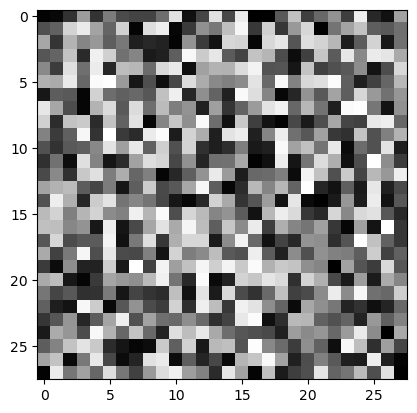

generation: 10, max fitness: -2.8399504969911504e-13
generation: 20, max fitness: -1.0436096431476471e-14
generation: 30, max fitness: 0.0
generation: 40, max fitness: -2.4424906541753444e-15
generation: 50, max fitness: -7.172040739078511e-14


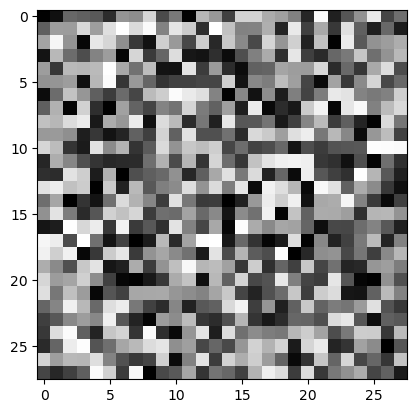

generation: 60, max fitness: -1.9095836023552692e-14
generation: 70, max fitness: -4.440892098500626e-16
generation: 80, max fitness: -4.440892098500626e-16
generation: 90, max fitness: -0.07390159971427013
generation: 100, max fitness: -2.220446049250313e-16


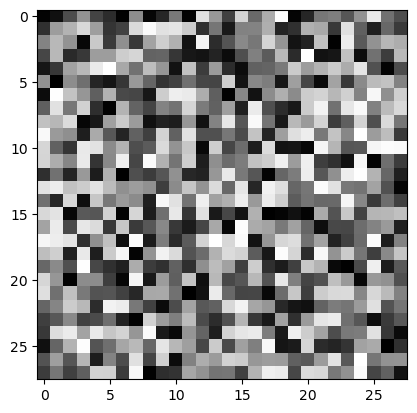

generation: 110, max fitness: -5.5289106626332796e-14
generation: 120, max fitness: -2.220446049250313e-16
generation: 130, max fitness: -3.064215547965432e-14
generation: 140, max fitness: -2.220446049250313e-16
generation: 150, max fitness: -4.218847493575595e-15


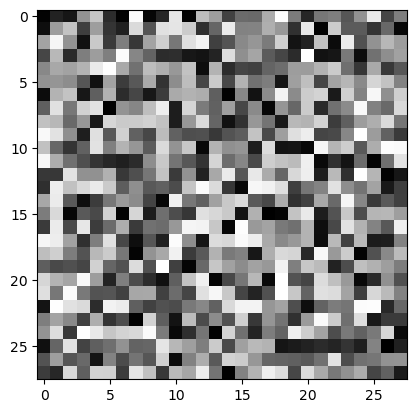

generation: 160, max fitness: -2.220446049250313e-16
generation: 170, max fitness: -7.993605777301127e-15
generation: 180, max fitness: -4.884981308350689e-15
generation: 190, max fitness: 0.0
generation: 200, max fitness: -6.217248937900877e-15


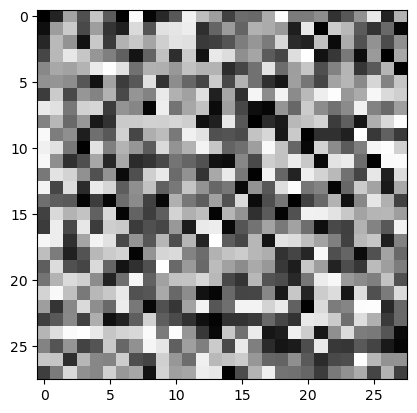

generation: 210, max fitness: -1.5543122344752192e-15
generation: 220, max fitness: -2.220446049250313e-16
generation: 230, max fitness: -2.220446049250313e-16
generation: 240, max fitness: -2.220446049250313e-16
generation: 250, max fitness: 0.0


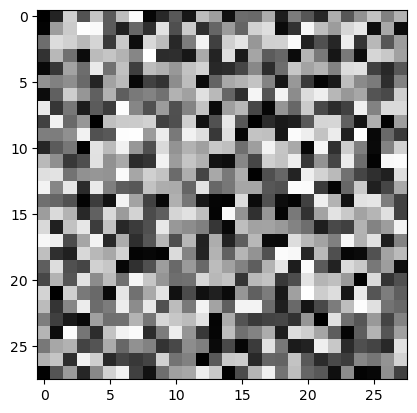

generation: 260, max fitness: 0.0
generation: 270, max fitness: -1.0880185641326534e-14
generation: 280, max fitness: -2.220446049250313e-16


KeyboardInterrupt: 

In [ ]:
genLog, fitnessLog, distLog, noiseLog, population, fitnesses = runGA(targetClass = 8)

## Plots and Outputs

In [ ]:
distCuttoff = l3
protosPerClass = 2

def getBestInd(population, fitnesses):
    return population[np.argmax(fitnesses)]

def getAllInds(population, fitnesses):
    bestInds = []
    farPopulation = population.tolist()
    farFitnesses = fitnesses.copy()

    # Loop while theres still some candidates and we still need more protos
    while(len(farPopulation) > 0 and len(bestInds) < protosPerClass):
        # Log best individual
        newBest = np.array(getBestInd(farPopulation, farFitnesses))
        bestInds.append(newBest)

        # remove everyone within the cuttoff (loop backwards)
        for i in range(len(farPopulation)-1, -1, -1):
            if(np.linalg.norm(newBest - population[i]) < distCuttoff):
                farPopulation.pop(i)
                farFitnesses.pop(i)

    return bestInds

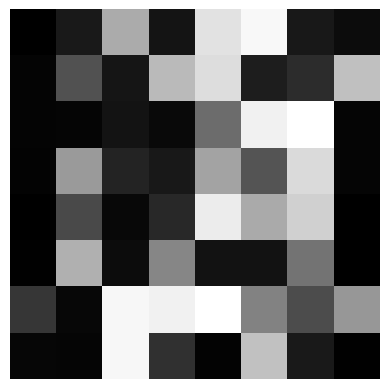

In [ ]:
allInds = getAllInds(population, fitnesses)

for i in range(0, len(allInds)):
    # Show best
    plt.imshow(allInds[i].reshape((sideLength, sideLength)), cmap='grey', interpolation='nearest')
    plt.axis("off")
    plt.savefig("sigma_protos/l3_"+str(l3)+"_"+str(i)+".png")

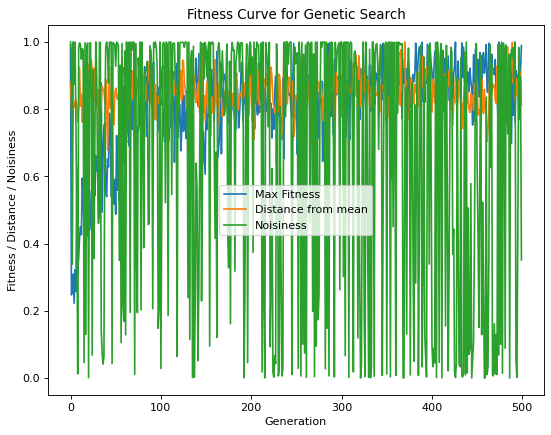

In [ ]:
# Regularise
distLog = distLog / np.max(distLog)
noiseLog = noiseLog / np.max(noiseLog)

# Plot fitness curve
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(genLog, fitnessLog, label="Max Fitness")
plt.plot(genLog, distLog, label="Distance from mean")
plt.plot(genLog, noiseLog, label="Noisiness")
plt.xlabel("Generation")
plt.ylabel("Fitness / Distance / Noisiness")
plt.legend()
plt.title("Fitness Curve for Genetic Search")
plt.show()

## Getting Prototypes from GA

### GA Prototypes

In [ ]:
def getGAPrototypes():
    # Run over unique y values
    prototypes = [None for _ in range(0, numClasses)]
    for c in np.unique(y_tr, axis=0):
        # Extract the class
        targetClass = np.where(c == 1)[0][0]

        # Run GA
        genLog, fitnessLog, distLog, noiseLog, population, fitnesses = runGA(targetClass = targetClass, logging=False)

        # Get and log best individual(s)
        bestInds = getAllInds(population, fitnesses)
        prototypes[targetClass] = bestInds

        print(targetClass)

    return prototypes

### Random Prototypes

In [ ]:
def getRandPrototypes():
    # shuffle data
    indices = np.arange(len(X_tr))
    np.random.shuffle(indices)
    data = X_tr[indices]
    targets = y_tr[indices]

    # Select random examples from each class
    randPrototypes = [[] for _ in range(0, numClasses)]

    # Initialize dictionary storing num occurences of each y which are logged
    usedYCounts = {}
    for i in range(0, len(np.unique(targets, axis=0))):
        usedYCounts[i] = 0

    # Loop through training data
    for i, datapoint in enumerate(data):
        # If we need the current y
        currentY = np.where(targets[i] == 1)[0][0]
        currentYCount = usedYCounts[currentY]
        if(currentYCount < protosPerClass):
            usedYCounts[currentY] += 1

            # log the datapoint
            randPrototypes[currentY].append(datapoint)

    return randPrototypes

### Mean Prototypes

In [ ]:
def getMeanPrototypes():
    meanPrototypes = [[] for _ in range(0, numClasses)]
    for i, average in enumerate(ave):
        for _ in range(0, protosPerClass):
            meanPrototypes[i].append(average)

    return meanPrototypes

## Repeat Prototype Generation

We will repeat all three methods of prototype generation for different random seeds = [0, 1, 2, ...].

The results will be stored in CSV files.

In [ ]:
def protosToFile(file, protos, rep):
    # Loop through each mnist number
    for i, protoList in enumerate(protos):

        # Loop through proto of that number
        for j, proto in enumerate(protoList):
            file.write(str(rep)+"|"+str(i)+"|"+str(proto.tolist())+"\n")

gaFile = open("protos/gaProtos.csv", "w")
gaFile.write("repetition|number|prototype\n")
gaFile.close()
gaFile = open("protos/gaProtos.csv", "a")

randFile = open("protos/randProtos.csv", "w")
randFile.write("repetition|number|proto\n")
randFile.close()
randFile = open("protos/randProtos.csv", "a")

meanFile = open("protos/meanProtos.csv", "w")
meanFile.write("repetition|number|proto\n")
meanFile.close()
meanFile = open("protos/meanProtos.csv", "a")

In [ ]:
repetitions = 10

for i in range(0, repetitions):
    print("REP: "+str(i))

    np.random.seed(i)
    random.seed(i)

    gaProtos = getGAPrototypes()
    protosToFile(gaFile, gaProtos, i)

    randProtos = getRandPrototypes()
    protosToFile(randFile, randProtos, i)

    meanProtos = getMeanPrototypes()
    protosToFile(meanFile, meanProtos, i)

gaFile.close()
randFile.close()
meanFile.close()

REP: 0
REP: 1
REP: 2
REP: 3
REP: 4
REP: 5
REP: 6
REP: 7
REP: 8
REP: 9


## Results

Read off these prototypes from their file and output some diagrams

In [ ]:
import ast
import matplotlib.pyplot as plt

def getProtosFromFile(filename):
    # Extract data from file
    file = open("protos/"+filename+".csv", "r")
    fileStr = file.read()
    file.close()
    lines = fileStr.split("\n")
    lines.pop(0)
    lines.pop(len(lines)-1)

    # Find num repetitions
    numReps = int(lines[len(lines) - 1].split("|")[0]) + 1

    # Loop through repetitions
    lineNum = 0
    ans = []
    for i in range(0, numReps):
        # Create empty set (list of 10 empty lists)
        set = [[] for _ in range(0, 10)]

        # Loop through every line in that rep
        while(lineNum < len(lines) and int(lines[lineNum].split("|")[0]) == i):
            l = lines[lineNum].split("|")
            rep = int(l[0])

            # Record proto in set
            number = int(l[1])
            proto = ast.literal_eval(l[2])
            set[number].append(proto)

            # increment
            lineNum += 1

        ans.append(set)
    return ans

def showProtos(protos):
    # Loop through sets
    for rep, set in enumerate(protos):
        # get max rows for figure
        maxRows = max(list(map(lambda l: len(l), set)))

        print("repetition: "+str(rep))
        fig, axs = plt.subplots(maxRows, 10)
        if(maxRows == 1):
            axs = [axs]
        plt.rcParams["figure.figsize"] = [10, maxRows]

        # Go through each 'round' of the set
        for round in range(0, maxRows):

            # Go through each proto
            for i in range(0, numClasses):
                if(round < len(set[i])):
                    proto = set[i][round]
                    axs[round][i].imshow(np.array(proto).reshape((8, 8)), cmap='grey', interpolation='nearest')
                    axs[round][i].axis("off")
                else:
                    axs[round][i].axis("off")

        plt.show()
        #fig.savefig("Proto Images/gaProtos"+str(rep)+".png")

In [ ]:
def showProtosIndividually(protos):
    protosReshaped = np.array(protos).reshape((-1, 8, 8))
    for i, im in enumerate(protosReshaped):
        plt.rcParams["figure.figsize"] = [1.5, 1.5]
        plt.imshow(im, cmap='grey', interpolation='nearest')
        plt.axis("off")
        plt.tight_layout()
        plt.savefig("Proto Images/00_denoised_fitness/gaProtos"+str(i)+".png")


### GA Prototypes

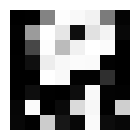

In [ ]:
gaProtos = getProtosFromFile("gaProtos")
showProtosIndividually(gaProtos)

### Random Prototypes

repetition: 0


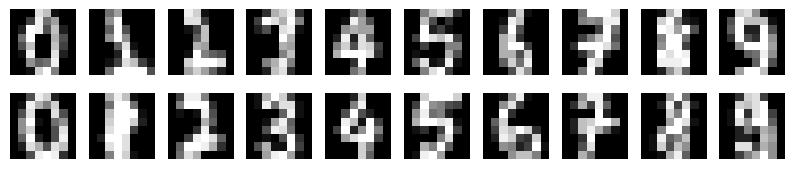

repetition: 1


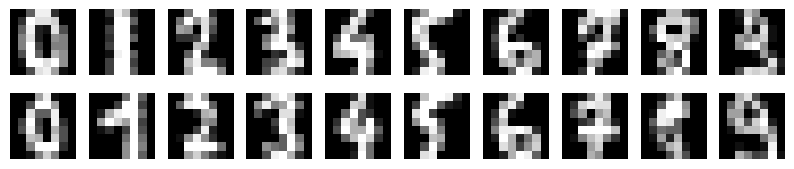

repetition: 2


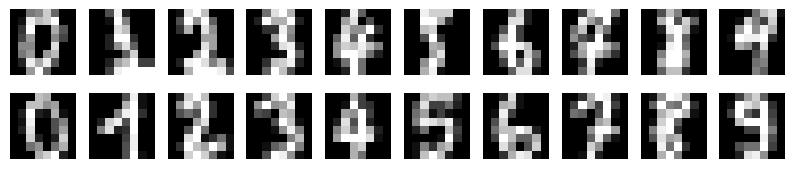

repetition: 3


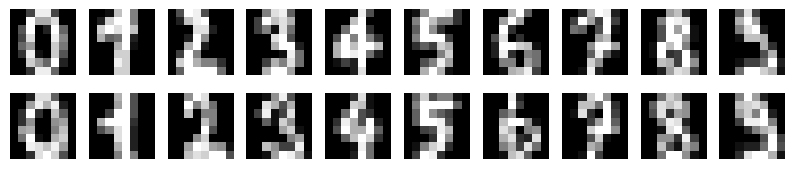

repetition: 4


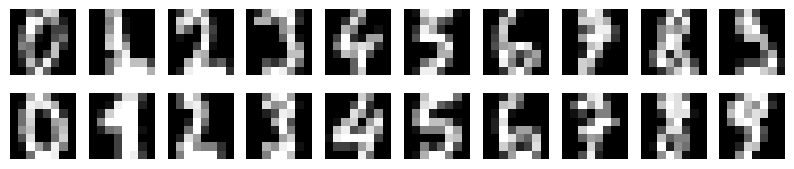

repetition: 5


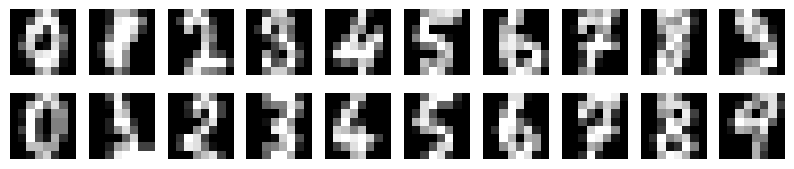

repetition: 6


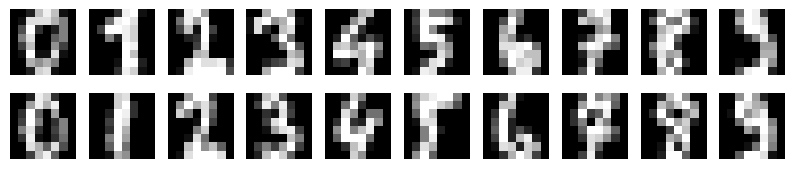

repetition: 7


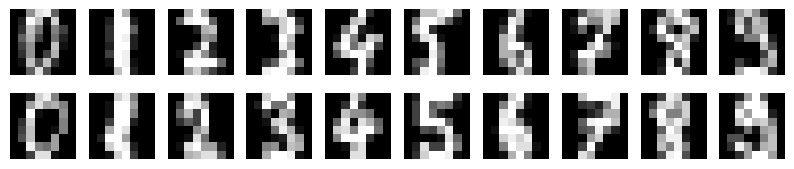

repetition: 8


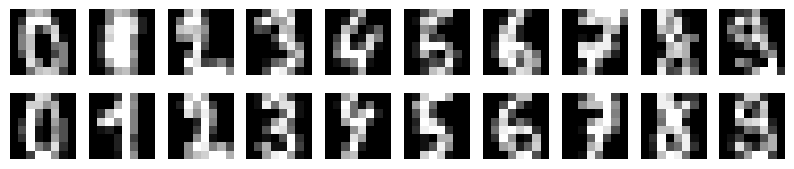

repetition: 9


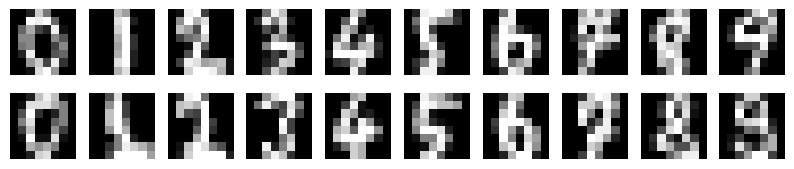

In [ ]:
randProtos = getProtosFromFile("randProtos")
showProtos(randProtos)

### Mean Prototypes

repetition: 0


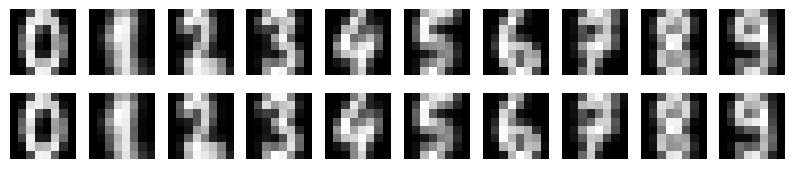

repetition: 1


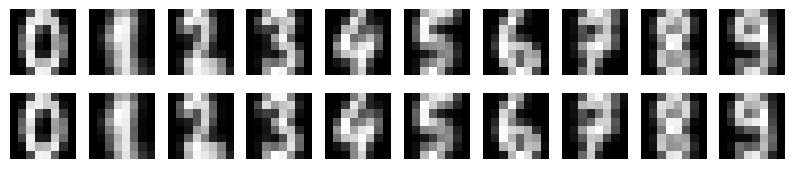

repetition: 2


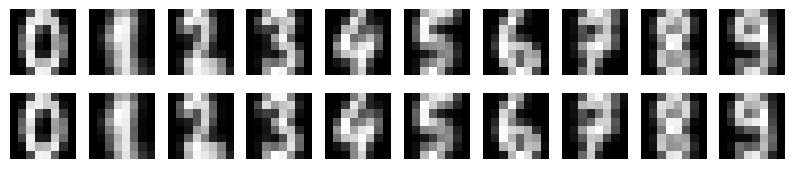

repetition: 3


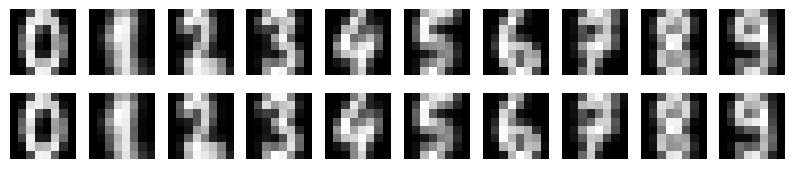

repetition: 4


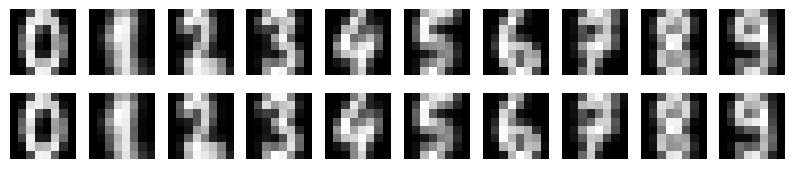

repetition: 5


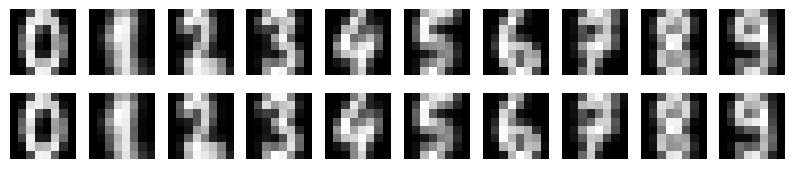

repetition: 6


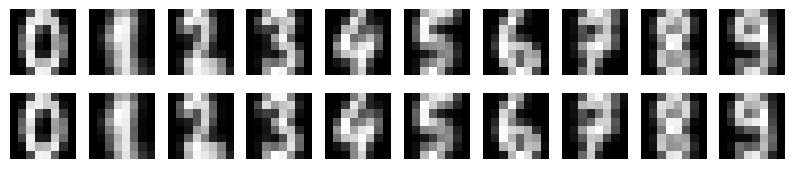

repetition: 7


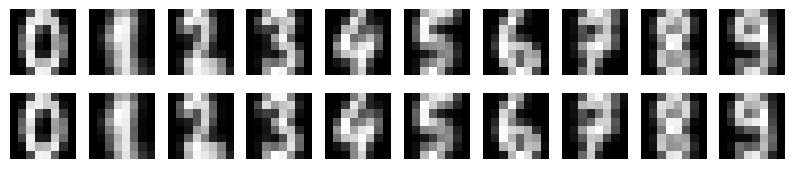

repetition: 8


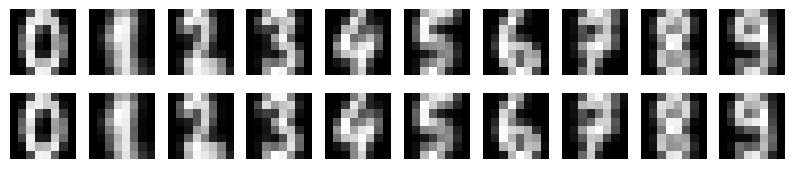

repetition: 9


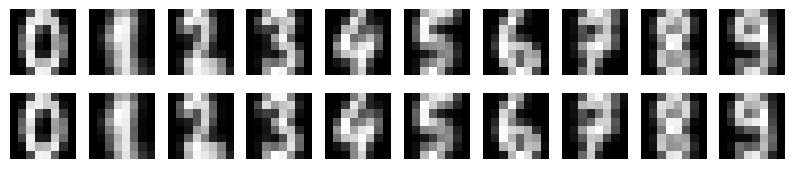

In [ ]:
meanProtos = getProtosFromFile("meanProtos")
showProtos(meanProtos)

## Evaluation

I evaluate these prototypes based on there accuracy classifing the test set using nearest neighbours.

I will compare this accuracy to the accuracy on two control models, one where the prototypes are randomly selected from their class, and one where they are the average.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

if(oneHotEncode):
    # Undo one hot encoding
    y_tr_old = list(map(lambda ohe: np.where(ohe == 1)[0][0], y_tr))
    y_test_old = list(map(lambda ohe: np.where(ohe == 1)[0][0], y_test))

In [ ]:
def evaluateProtos(protos):
    repetitions = len(protos)
    accuracies = []

    # construct 1D array of ys for evaluation
    eval_y_s = []
    for rep in range(0, repetitions):
        for num in range(0, numClasses):
            eval_y_s = eval_y_s+[num for _ in range(0, len(protos[rep][num]))]

    # Do evaluation
    for rep in range(0, repetitions):
        # construct 1D array of ys for evaluation
        eval_y_s = []
        for num in range(0, numClasses):
            eval_y_s = eval_y_s+[num for _ in range(0, len(protos[rep][num]))]

        # Reshape
        protosReshaped = np.array(protos[rep]).reshape((-1, 64))

        # Train and evaluate
        nn = KNeighborsClassifier(n_neighbors=1).fit(protosReshaped, eval_y_s)
        accuracy = nn.score(X_test, y_test_old)
        accuracies.append(accuracy)

    return np.array(accuracies)

### GA Prototypes

In [ ]:
gaAccuracies = evaluateProtos(gaProtos)

print("Nearest neighbour on GA prototypes mean accuracy: "+str(np.mean(gaAccuracies)))
print("Nearest neighbour on GA prototypes accuracy variance: "+str(np.var(gaAccuracies)))

Nearest neighbour on GA prototypes mean accuracy: 0.6377777777777778
Nearest neighbour on GA prototypes accuracy variance: 0.0007148148148148156


### Random Prototypes

In [ ]:
randAccuracies = evaluateProtos(randProtos)

print("Nearest neighbour on random prototypes mean accuracy: "+str(np.mean(randAccuracies)))
print("Nearest neighbour on random prototypes accuracy variance: "+str(np.var(randAccuracies)))

Nearest neighbour on random prototypes mean accuracy: 0.7355555555555556
Nearest neighbour on random prototypes accuracy variance: 0.001198765432098765


### Mean Prototypes

In [ ]:
meanAccuracies = evaluateProtos(meanProtos)

print("Nearest neighbour on mean prototypes mean accuracy: "+str(np.mean(meanAccuracies)))
print("Nearest neighbour on mean prototypes accuracy variance: "+str(np.var(meanAccuracies)))

Nearest neighbour on mean prototypes mean accuracy: 0.7
Nearest neighbour on mean prototypes accuracy variance: 0.0


### Evaluation Plot

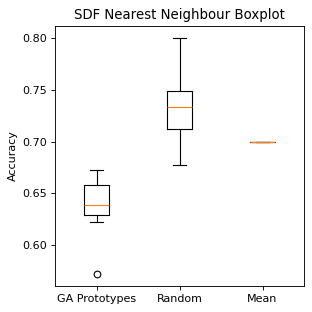

In [ ]:
combinedData = np.concatenate((gaAccuracies.reshape((-1, 1)),
                               randAccuracies.reshape((-1, 1)),
                               meanAccuracies.reshape((-1, 1))), axis=1)

fig = plt.figure(figsize=(4, 4), dpi=80)
plt.boxplot(combinedData, labels=["GA Prototypes", "Random", "Mean"])
plt.title("SDF Nearest Neighbour Boxplot")
plt.ylabel("Accuracy")
plt.tight_layout()
#fig.savefig("BoxplotDenoised.png")

## Exploration

In [ ]:
# Train and evaluate
nnga = KNeighborsClassifier(n_neighbors=1).fit(gaProtos[0], range(10))
predictions = nnga.predict(X_test)

# Loop through predictions
mistakes = {}
for i, pred in enumerate(predictions):
    # If it's wrong
    if(not pred == y_test_old[i]):
        # Create the mistake index
        if(pred < y_test_old[i]):
            index = str(pred)+str(y_test_old[i])
        else:
            index = str(y_test_old[i])+str(pred)

        # Log the mistake
        if(not index in mistakes):
            mistakes[index] = 1
        else:
            mistakes[index] += 1

# Output results
for key in mistakes.keys():
    print(key[0]+" and "+key[1]+" were mistaken "+str(mistakes[key])+" times.")

### PCA Plot

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce training data using PCA
pca = PCA(random_state=randomSeed).fit(X_tr)
reducedData = pca.transform(X_tr)

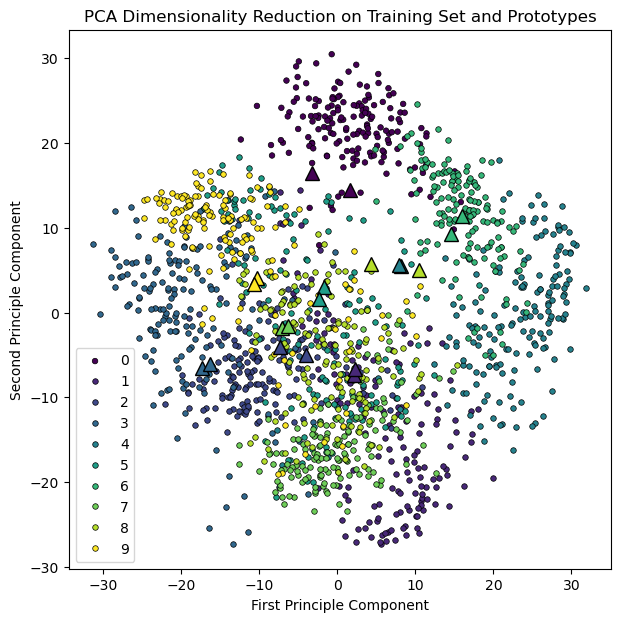

In [ ]:
# Group PCA reduced data into classes (so we can plot each class seperatley for legend)
groupedReducedData = [[] for _ in range(0, numClasses)]
for i, rd in enumerate(reducedData):
    groupedReducedData[y_tr_old[i]].append(rd)

# Plot each class seperatley (for legend)
plt.rcParams["figure.figsize"] = (7, 7)
fig, axs = plt.subplots()
cm = plt.get_cmap("viridis")
for i in range(0, numClasses):
    data = groupedReducedData[i]
    fpc = list(map(lambda x: x[0], data))
    spc = list(map(lambda x: x[1], data))

    if(i == 0):
        axs.scatter(fpc, spc,
                    c=[(i/9) for _ in range(0, len(data))],
                    label=str(i),
                    cmap="viridis",
                    edgecolors="black",
                    s=16, linewidth=0.5)
    else:
        axs.plot(fpc, spc,
                 ".", c=cm(i/9),
                 label=str(i),
                 markersize=8,
                 markeredgecolor="black",
                 markeredgewidth=0.5)

# Reduce prototypes using PCA
for i, protoList in enumerate(gaProtos[0]):
    reducedProtos = pca.transform(protoList)
    axs.plot(reducedProtos[0][0], reducedProtos[0][1], "^", c=cm(i/9), markeredgecolor="black", markersize=10)
    axs.plot(reducedProtos[1][0], reducedProtos[1][1], "^", c=cm(i/9), markeredgecolor="black", markersize=10)

plt.legend()
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
plt.title("PCA Dimensionality Reduction on Training Set and Prototypes")
#plt.savefig("pcaSharing.png")